# GLMM

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpboost as gpb
from patsy import dmatrix
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [9]:
filepath = '../../../../data/processed/df_filtered_5years_exclude_too_far_islands.xlsx'
df = pd.read_excel(filepath)
df = df[df['island_id'] != 191] # この島は変化率が無限大になるので除外
df.dropna(inplace=True)

In [10]:
df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()
df['log_income'] = np.log(df['income'])
df['log_area'] = np.log(df['area_km2'])
df['log_distance'] = np.log(df['distance_m'])
df = df.dropna()

In [13]:
group = df['island_id']
y = df['population_change_rate']
X = dmatrix('dummy_after_bridge_opened + log_income + C(year)', data=df, return_type='dataframe')

model = gpb.GPModel(group_data=group, likelihood='gaussian') # 正規分布
model.fit(y=y, X=X, params={'std_dev': True})

pred = model.predict(X_pred=X, group_data_pred=group)['mu']
residuals = y - pred

print(model.summary())

Model summary:
 Log-lik     AIC     BIC
  220.86 -419.72 -374.62
Nb. observations: 446
Nb. groups: 90 (island_id)
-----------------------------------------------------
Covariance parameters (random effects):
            Param.  Std. dev.
Error_term  0.0216     0.0016
island_id   0.0001     0.0007
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                           Param.  Std. dev.  z value  P(>|z|)
Intercept                 -0.0433     0.1074  -0.4032   0.6868
C(year)[T.1995]            0.0017     0.1344   0.0125   0.9900
C(year)[T.2000]           -0.0304     0.1061  -0.2870   0.7741
C(year)[T.2005]            0.0342     0.1066   0.3214   0.7479
C(year)[T.2010]           -0.0185     0.1066  -0.1738   0.8620
C(year)[T.2015]           -0.0347     0.1065  -0.3254   0.7449
C(year)[T.2020]           -0.0641     0.1065  -0.6012   0.5477
dummy_after_bridge_opened  0.0469     0.0142   3.2996   0.0010
log_income                -0.0090

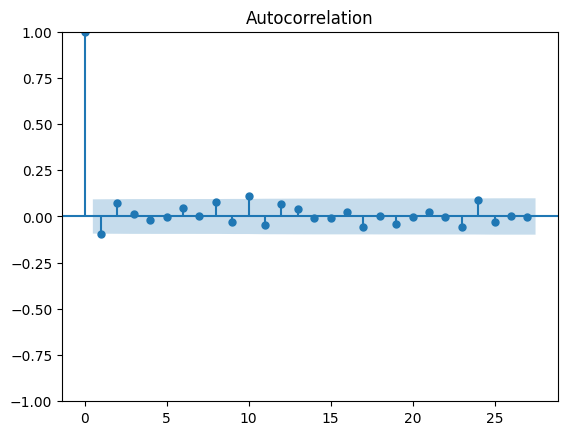

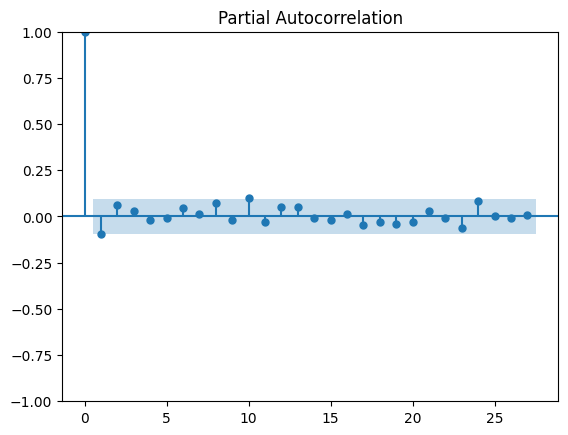

In [5]:
# ACF plot
plot_acf(residuals)
plt.show()

# PACF plot
plot_pacf(residuals)
plt.show()